<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#CIFAR-10-Results" data-toc-modified-id="CIFAR-10-Results-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>CIFAR-10 Results</a></span></li></ul></div>

# Imports

In [1]:
import os
from os.path import join
import numpy as np


# Plotting imports
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}", r'\usepackage{amssymb}', r'\usepackage{amsmath}',
                                    r'\usepackage{wasysym}']
params = {'text.usetex' : True,
          'font.size' : 20,
          'font.family' : 'sans-serif',
          'font.serif' : 'Computer Modern Sans serif',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 


from interpretability.utils import explainers_color_map 


#loading results for plotting
from project_utils import get_precomputed_results
get_precomputed_results()

def joined_listdir(path):
    return [(join(path, d), d) for d in os.listdir(path)]

/BS/restricted_networks/work/anaconda3/envs/torch1.6/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


In [2]:
exps = ['pretrained-densenet121',
        'densenet_121_cossched',
        'densenet_121',
        'pretrained-resnet34',
        'resnet_34',
        'pretrained-vgg11',
        'vgg_11',
        'pretrained-inception',
        'inception_v3']

In [3]:
results = {}
for exp in exps:
    exp_results = {}
    for mdir, method in joined_listdir(join("results", exp, "localisation")):
        exp_results[method] = np.loadtxt(join(mdir, "localisation_metric.np"))
    results.update({exp: exp_results})

In [4]:
pairs = [
     ('pretrained-densenet121', 'densenet_121_cossched', "DenseNet-121"), 
     ('pretrained-resnet34', 'resnet_34', "ResNet-34"),
     ('pretrained-vgg11', 'vgg_11', "VGG-11"),
     ('pretrained-inception', 'inception_v3', "InceptionNet"), 
]

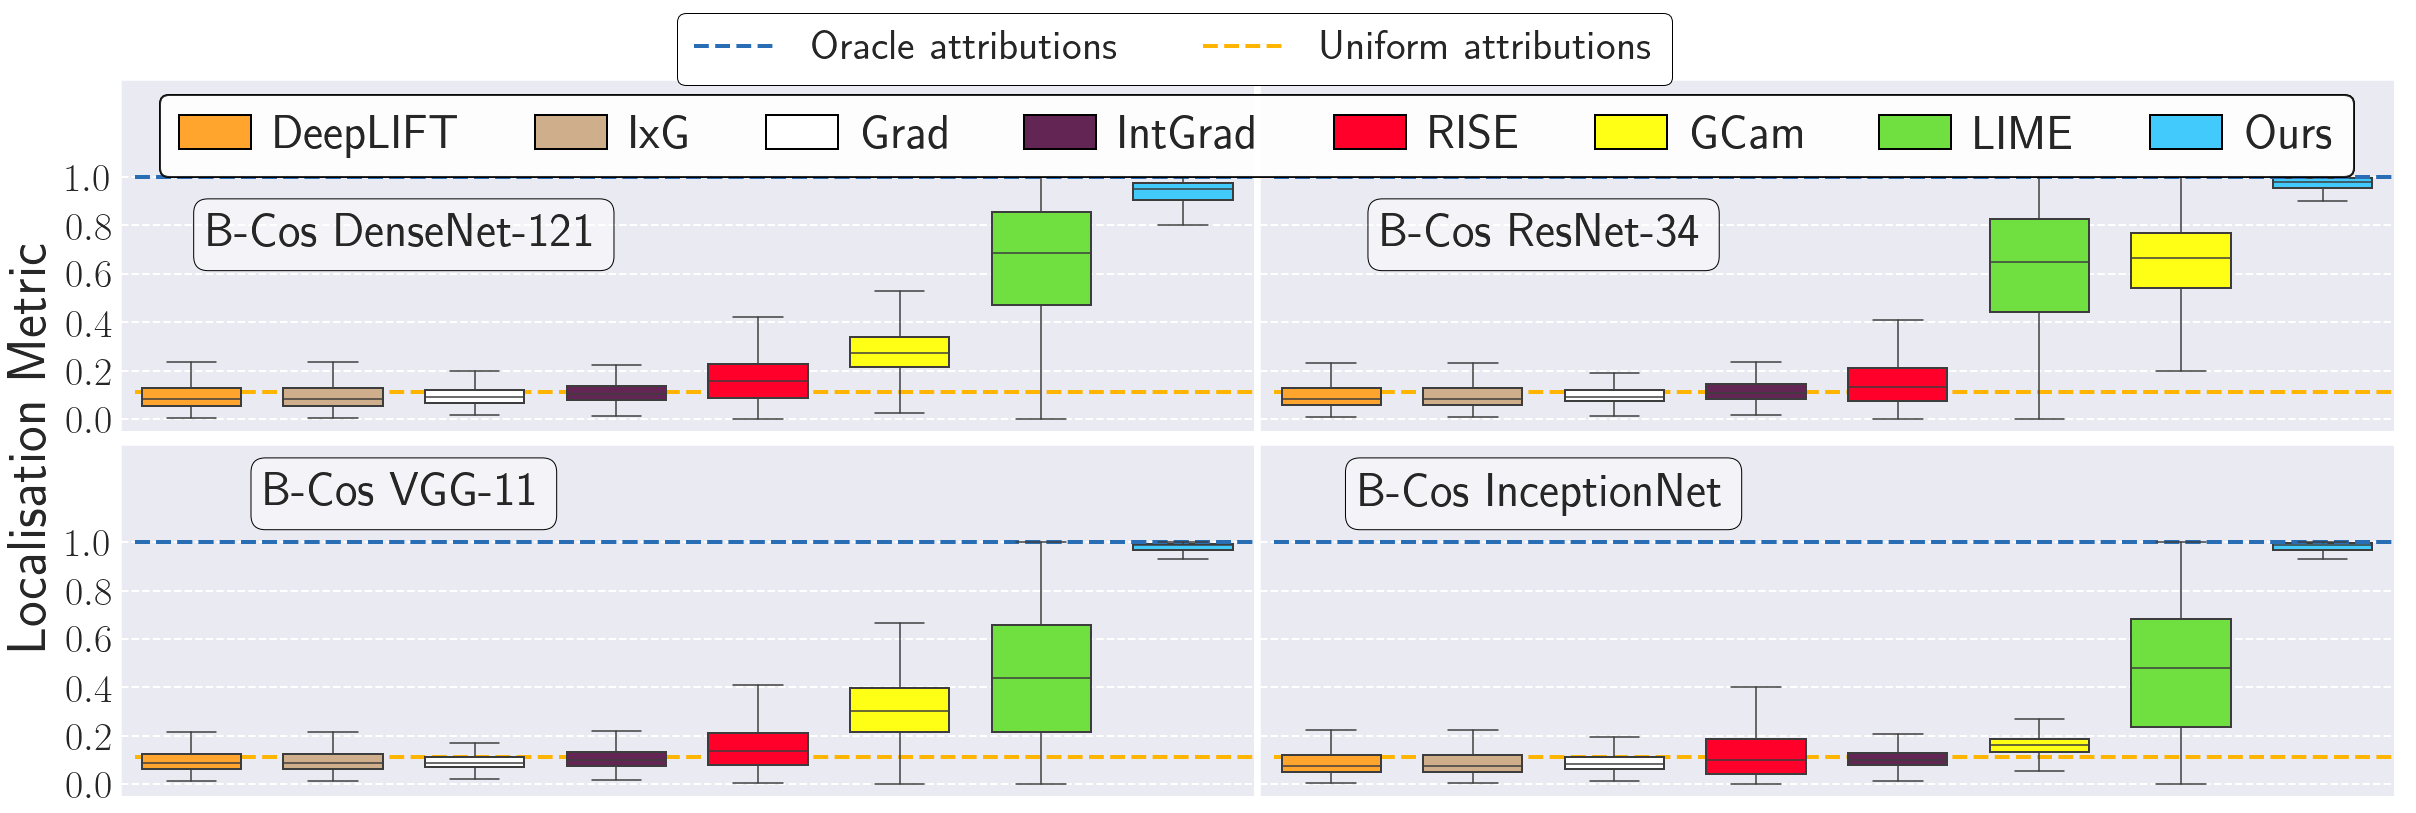

In [5]:
n_imgs = 9
fig, axes = plt.subplots(2, 2, figsize=(45 * .725, 12 * .725))    
pretrained = False
labels_ordered = None
for ax_idx, (p, ax) in enumerate(zip(pairs, axes.flatten())):
    offset = 0
    labels1 = np.array(sorted(results[p[0]].items(),
                                     key=lambda x: np.percentile(x[1], 50))).T.tolist()[0] + ["Ours"]
    labels2, _ = np.array(sorted(results[p[1]].items(),
                                     key=lambda x: np.percentile(x[1], 50), 
                                    reverse=False)).T.tolist()
    total = len(labels1 if pretrained else labels2)
    if labels_ordered is None:
        labels_ordered = labels1 if pretrained else labels2
    l1 = ax.hlines([1], -.4, total,
                   alpha=1, linestyle="dashed", label="Oracle", lw=4, 
                   color=np.array((41, 110, 180), dtype=float)/255, zorder=20)
    l2 = ax.hlines([(1/n_imgs)], -.4, total, alpha=1, linestyle="dashed", lw=4,
              label="Uniform", color=np.array((255, 180, 0), dtype=float)/255, zorder=20)
    box_plot = sns.boxplot(data=(
        ([results[p[0]][l] for l in labels1[:-1]] + [results[p[1]]["Ours"]]) if pretrained else
        [results[p[1]][l] for l in labels2]
        
    ), ax=ax, fliersize=0, zorder=50, width=.7)
    for i, l in enumerate(labels1 if pretrained else labels2):
        mybox = box_plot.artists[i]
        mybox.set_facecolor(np.array(explainers_color_map[l])/255)
        mybox.set_linewidth(2)
        mybox.set_zorder(20)
    
    ax.set_xticks([])
    ax.tick_params(axis='y', which='major', labelsize=34)

    ax.add_artist(l1)

    if ax_idx >= 2:
        ax.annotate(("B-Cos " if not pretrained else "Pretrained ") + p[2], xy=(0.25, 1.2),
                    xycoords=("axes fraction", "data"),
                  fontsize=48, ha="center", va="center", bbox=dict(boxstyle="round", fc=(1, 1, 1, .5), 
                                                     ec="black", lw=1))
    else:
        ax.annotate(("B-Cos " if not pretrained else "Pretrained ") + p[2], xy=(0.25, .45+.075), 
                    xycoords=("axes fraction", "axes fraction"),
          fontsize=48, ha="center", bbox=dict(boxstyle="round", fc=(1, 1, 1, .5), 
                                             ec="black", lw=1))
    
    ax.set_ylim(ax.get_ylim()[0], 1.4 if ax_idx >=2 else 1.4)
    
    if pretrained:
        ax.vlines([len(labels1)-1.5], -2, 2, linestyle=(1, (4, 2)), linewidth=4)
        ax.annotate("B-cos", xy=(len(labels1)-1, .5), xycoords=("data", "data"),
                      fontsize=32, ha="center", va="center", bbox=dict(boxstyle="round", fc=(1, 1, 1, .5), 
                                                         ec="black", lw=1), rotation=90)
    ax.set_yticks(np.arange(0, 1.2, .2))
    ax.set_yticklabels(["${:.1f}$".format(l) for l in np.arange(0, 1.2, .2)], fontsize=40)
    if ax_idx % 2 == 1:
        ax.tick_params("y", labelleft=False, which="both")

    ax.grid(linewidth=2, color="white", zorder=-10)
    ax.set_xlim(-.5, total -1 + .5)
    ax.grid(zorder=-10, linestyle="dashed", alpha=1, axis="y")
legend_elements = [Patch(facecolor=np.array(explainers_color_map[l])/255,
                         edgecolor='black', lw=2,
                         label=l) for l in labels_ordered]

fig.tight_layout(h_pad=0, w_pad=.65, rect=(0, 0, 1, 1.2))
ax = fig.add_axes([0, 1.2, 1, .1])
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor("white")


leg = fig.legend(handles=legend_elements, loc='upper center', ncol=len(labels1),
                 fontsize=48, bbox_to_anchor=[.535, 1.175+0.01], handlelength=1.5,
                  columnspacing=1.5, handletextpad=.5, 
                 facecolor="w", edgecolor="black",
                )
leg.set_in_layout(True)

leg.get_frame().set_linewidth(2)

legend_elements = [Line2D([0], [0], color=np.array((41, 110, 180), dtype=float)/255,
                          lw=4, label='Oracle attributions', linestyle="dashed"),
                   Line2D([0], [0], color=np.array((255, 180, 0), dtype=float)/255,
                          lw=4, label='Uniform attributions', linestyle="dashed")
                   
                  ]

leg2 = fig.legend(handles=legend_elements, loc='upper center', ncol=2,
           fontsize=42, bbox_to_anchor=[.5, 1.3+0.01],
           facecolor="w", edgecolor="black", framealpha=1, 
          )
txt = plt.figtext(-.01, .6, "Localisation Metric", rotation=90, fontsize=55, va="center", ha="center")
fig.add_artist(leg)
fig.set_facecolor("white")


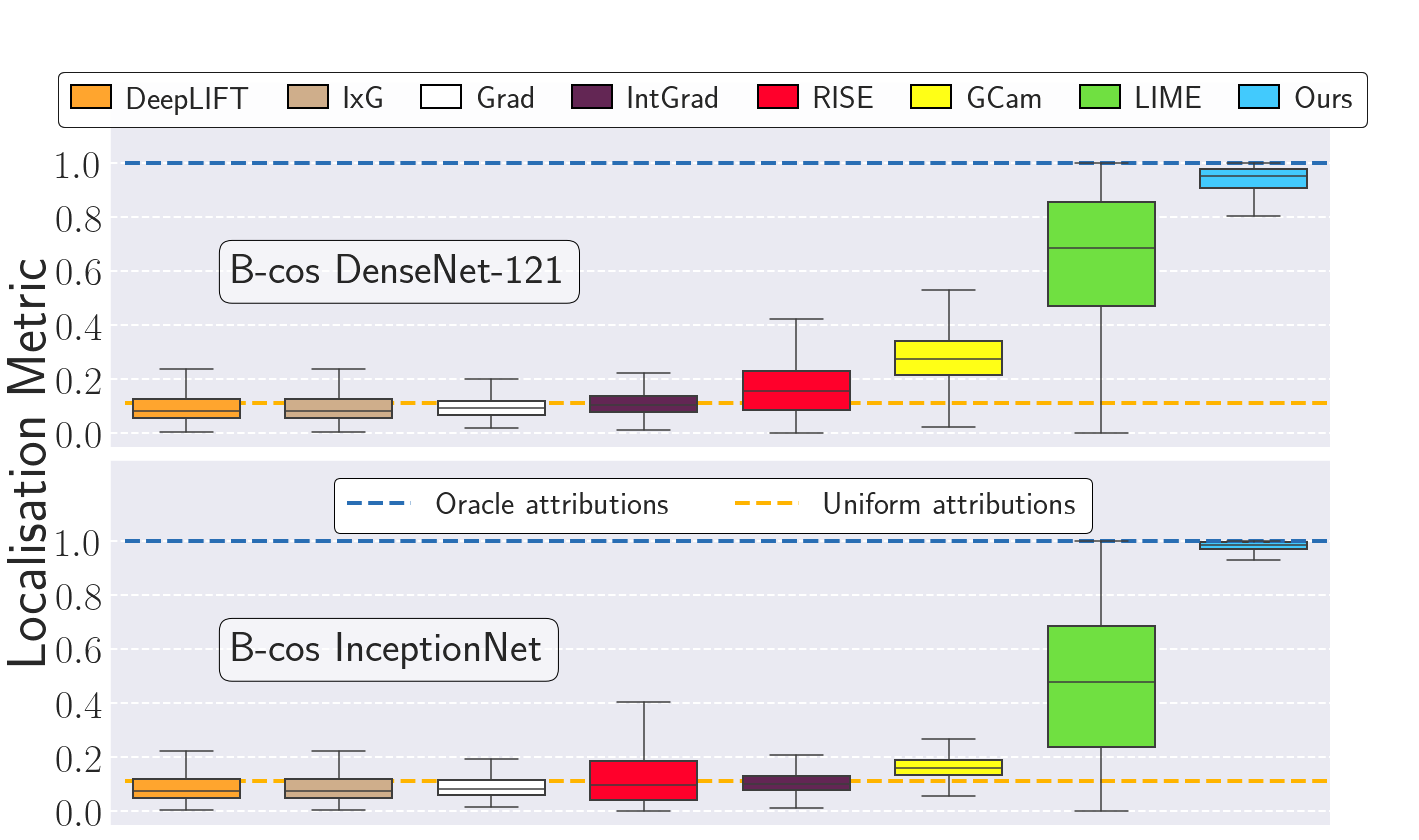

In [6]:
n_imgs = 9
fig, axes = plt.subplots(2, 1, figsize=(60 * .6 / 2, 15 * .6))    
label_order = None
for ax_idx, (p, ax) in enumerate(zip(pairs[::3], axes.flatten())):
    offset = 0
    labels1, _ = np.array(sorted(results[p[0]].items(),
                                     key=lambda x: np.percentile(x[1], 50))).T.tolist()
    labels2, _ = np.array(sorted(results[p[1]].items(),
                                     key=lambda x: np.percentile(x[1], 50), 
                                    reverse=False)).T.tolist()
    if label_order is None:
        label_order = labels2

    total = len(labels2)
    l1 = ax.hlines([1], -.4, total,
                   alpha=1, linestyle="dashed", label="Oracle", lw=4, 
                   color=np.array((41, 110, 180), dtype=float)/255, zorder=20)
    l2 = ax.hlines([(1/n_imgs)], -.4, total, alpha=1, linestyle="dashed", lw=4,
              label="Uniform", color=np.array((255, 180, 0), dtype=float)/255, zorder=20)
    box_plot = sns.boxplot(data=(
        [results[p[1]][l] for l in labels2]
        
    ), ax=ax, fliersize=0, zorder=50, width=.7)
    for i, l in enumerate(labels2):
        mybox = box_plot.artists[i]
        mybox.set_facecolor(np.array(explainers_color_map[l])/255)
        mybox.set_linewidth(2)
        mybox.set_zorder(20)
    
    ax.set_xticks([])
    ax.tick_params(axis='y', which='major', labelsize=34)

    ax.add_artist(l1)

    if ax_idx >= 2:
        ax.annotate("B-cos " + p[2], xy=(0.1, .6), xycoords=("axes fraction", "axes fraction"),
                  fontsize=42, bbox=dict(boxstyle="round", fc=(1, 1, 1, .5), 
                                                     ec="black", lw=1))
    else:
        ax.annotate("B-cos " + p[2], xy=(0.1, .45), xycoords=("axes fraction", "axes fraction"),
          fontsize=42, bbox=dict(boxstyle="round", fc=(1, 1, 1, .5), 
                                             ec="black", lw=1))

    ax.set_ylim(ax.get_ylim()[0], 1.1 if ax_idx >=2 else 1.3)
    if ax_idx %2 == 0 or True:

        ax.set_yticks(np.arange(0, 1.2, .2))
        ax.set_yticklabels(["${:.1f}$".format(l) for l in np.arange(0, 1.2, .2)], fontsize=40)
    
    ax.grid(linewidth=2, color="white", zorder=-10)

    ax.set_xlim(-.5, total -1 + .5)
    ax.grid(zorder=-10, linestyle="dashed", alpha=1, axis="y")
unique_entries = [l for l in explainers_color_map.keys() if l in labels1 + labels2]
legend_elements = [Patch(facecolor=np.array(explainers_color_map[l])/255,
                         edgecolor='black', lw=2,
                         label=l) for l in label_order]

leg.set_in_layout(True)
leg.get_frame().set_linewidth(2)
fig.tight_layout(h_pad=0, w_pad=.65, rect=(0, 0, 1, 1.2))
ax = fig.add_axes([0, 1.2, 1, .1])
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor("white")


leg = fig.legend(handles=legend_elements, loc='upper center', ncol=len(unique_entries),
                 fontsize=32, bbox_to_anchor=[.55, 1.15+0.06], handlelength=1.25,
                  columnspacing=1.1, handletextpad=.5, 
                 facecolor="w", edgecolor="black",
                )

legend_elements = [Line2D([0], [0], color=np.array((41, 110, 180), dtype=float)/255,
                          lw=4, label='Oracle attributions', linestyle="dashed"),
                   Line2D([0], [0], color=np.array((255, 180, 0), dtype=float)/255,
                          lw=4, label='Uniform attributions', linestyle="dashed")
                   
                  ]

leg2 = fig.legend(handles=legend_elements, loc='upper center', ncol=2,
           fontsize=32, bbox_to_anchor=[.55, .5+0.06], borderaxespad=0.025,
           facecolor="w", edgecolor="black", framealpha=1, 
          )
txt = plt.figtext(-.01, .6, "Localisation Metric", rotation=90, fontsize=55, va="center", ha="center")
fig.add_artist(leg)
fig.set_facecolor("white")


# CIFAR-10 Results

In [7]:
from experiments.CIFAR10.bcos.experiment_parameters import exps as c10_exps

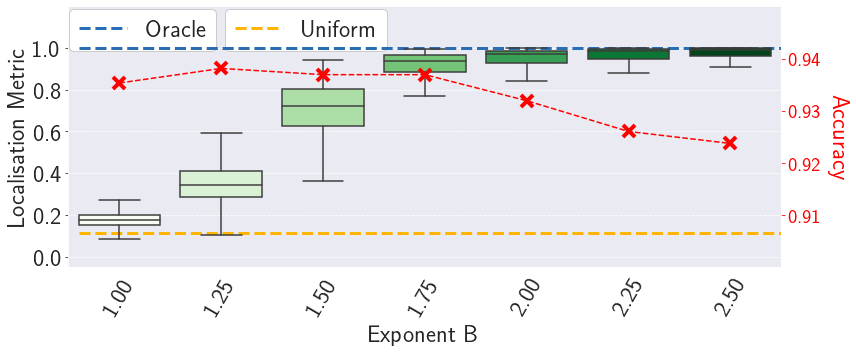

In [8]:
fontsize = 24
sns.set_style("darkgrid")
results = []
labels = []
# final accs of models
accs = np.array([93.53, 93.81, 93.69, 93.69, 93.19, 92.6,  92.37])/100
for e in c10_exps.keys():
    results.append(np.loadtxt(join("results", "c10", e, "localisation_metric.np")))
    labels.append(e)


fig, ax = plt.subplots(1, figsize=(12, 5))
n_imgs = 9

l1 = ax.hlines([1], -.4, len(results), alpha=1, linestyle="dashed", label="Oracle", lw=3, 
               color=np.array((41, 110, 180), dtype=float)/255, zorder=20)
l2 = ax.hlines([(1/n_imgs)], -.4, len(results), alpha=1, linestyle="dashed", lw=3,
          label="Uniform", color=np.array((255, 180, 0), dtype=float)/255, zorder=20)
box_plot = sns.boxplot(data=results, ax=ax, fliersize=0, zorder=50)

ax.set_xticks(range(len(results)))
ax.tick_params(axis='y', which='major', labelsize=fontsize)

ax.set_xticklabels([l.replace("_", "-") for l in labels], rotation=60, fontsize=fontsize)
l1 = ax.legend([l1], ["Oracle"], loc="upper right", bbox_to_anchor=(.21, 1), facecolor="white", framealpha=1,
              borderaxespad=0.1, fontsize=fontsize)
ax.legend([l2], ["Uniform"], loc="upper right", bbox_to_anchor=(.45, 1), facecolor="white", framealpha=1,
         borderaxespad=0.1, fontsize=fontsize)

plt.gca().add_artist(l1)
ax.set_ylabel("Localisation Metric", fontsize=24)
ax.set_yticks(np.arange(0, 1.2, .2))
ax.set_ylim(ax.get_ylim()[0], 1.2)
ax.set_xlim(-.5, len(results) - 1  + .5)
ax.grid(zorder=-10, linestyle="dashed", alpha=1, axis="y")
fig.tight_layout()
fig.set_facecolor("white")

ax.set_xlabel("Exponent B", fontsize=24)
ax.set_yticks(np.arange(.0, 1.1, 0.2))
ax.set_yticklabels(["{:.1f}".format(y) for y in np.arange(.0, 1.1, 0.2)])
ax = ax.twinx()
ax.set_xticklabels(["{:.2f}".format(b) for b in [1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50]], fontsize=fontsize)
cmap = matplotlib.cm.get_cmap('Greens')
colours = [cmap(i) for i in np.linspace(0, 1, len(c10_exps))]
for i, k in enumerate(colours):
    mybox = box_plot.artists[i]
    mybox.set_facecolor(k)
    mybox.set_zorder(20)
    
ax.plot(np.arange(len(c10_exps)), accs, "x--", color="red", markersize=12, markeredgewidth=4)
ax.set_ylim((.90, .95))
ax.set_yticks([.91, .92, .93, .94])
ax.set_yticklabels(["{:.2f}".format(y) for y in [.91, .92, .93, .94]])
ax.tick_params("y", labelcolor="red", color="red", labelsize=20)
ax.grid(False)
ax.set_ylabel("Accuracy", color="red", fontsize=24, rotation=270, labelpad=28)
fig.tight_layout()
